1、对抗训练D时，加入G的gumbel sample数据作为假数据，G比D多训练5倍

2、pretrain和对抗训练D时，都加入G的gumbel sample，temp=0.7 --》效果不行

3、pretrain和对抗训练D时，不都加入G的gumbel sample，temp=0.4, 对抗训练G时，更新context
参数，G的out层也进行更新

4、与3参数相同，但D最后一层采用consine similarity

5、maxlen为40, D用cosine，效果不好

6、maxlen为40, D不用cosine，生成句子太长，有点无厘头

7、maxlen为30, D不用cosine

8、maxlen为30, D不用cosine，temp=0.6, 效果不好

9、maxlen为30，训练G时同时更新out和rnn, window[1, 2, 3]， 100 channel， 效果很好

10、maxlen为30，训练G时同时更新out和rnn, window[1, 2]， 150 channel，效果还行

11、maxlen为30，训练G时同时更新out和rnn, window[2, 3]， 100 channel,相关性太低，多样性还行

In [12]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.init as weight_init
import numpy as np
from time import time
import data
import sys
from metrics import Metrics
import random
import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = torch.device('cuda:0')


In [13]:
def config_HRED():
    conf = {
    'maxlen':30, # maximum utterance length
    'diaglen':10, # how many utterance kept in the context window

# Model Arguments
    'emb_size':200, # size of word embeddings
    'n_hidden':300,
    'gru_hidden_utter_encode':300, # number of hidden units of utterance encoder
    'gru_hidden_context_encode':300,
    'gru_hidden_decode':300,
    'n_layers':1, # number of layers
    'gru_hidden_dis_rel':300,
    'filter_channel_dis_rel':[100, 100],
    'filter_sizes_dis_rel':[2, 3],
    'linear_dis_rel':300,
    'noise_radius':0.2, # stdev of noise for autoencoder (regularizer)
    'lambda_gp':10, # Gradient penalty lambda hyperparameter.
    'temp':1.0, # softmax temperature (lower --> more discrete)
    'dropout':0.5, # dropout applied to layers (0 = no dropout)

# Training Arguments
    'batch_size':32,
    'epochs':100, # maximum number of epochs
    'min_epochs':2, # minimum number of epochs to train for

    'n_iters_d':3, # number of discriminator iterations in training
    'lr_ae':0.001, # autoencoder learning rate
    'lr_gan_g':1e-04, # generator learning rate
    'lr_gan_d_rel':1e-04, # critic/discriminator learning rate
#     'lr':0.001, # autoencoder learning rate
    'beta1':0.9, # beta1 for adam
    'clip':1.0,  # gradient clipping, max norm
    'gan_clamp':0.01,  # WGAN clamp (Do not use clamp when you apply gradient penelty             
    }
    return conf 

config = config_HRED()

In [14]:
def gData(data):
    tensor=data
    if isinstance(data, np.ndarray):
        tensor = torch.from_numpy(data)
    tensor=tensor.to(DEVICE)
    return tensor

def gVar(data):
    return gData(data)
def print_flush(data, args=None):
    if args == None:
        print(data)
    else:
        print(data, args)
    sys.stdout.flush()
    
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    if torch.cuda.is_available():
        U = U.to(DEVICE)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def get_fixed_temperature(temper, i, N, adapt):
    if adapt == 'no':
        temper_var_np = temper  # no increase
    elif adapt == 'lin':
        temper_var_np = 1 + i / (N - 1) * (temper - 1)  # linear increase
    elif adapt == 'exp':
        temper_var_np = temper ** (i / N)  # exponential increase
    elif adapt == 'log':
        temper_var_np = 1 + (temper - 1) / np.log(N) * np.log(i + 1)  # logarithm increase
    return temper_var_np
    
def indexes2sent(indexes, vocab, eos_tok, ignore_tok=0): 
    '''indexes: numpy array'''
    def revert_sent(indexes, ivocab, eos_tok, ignore_tok=0):
        toks=[]
        length=0
        indexes=filter(lambda i: i!=ignore_tok, indexes)
        for idx in indexes:
            toks.append(ivocab[idx])
            length+=1
            if idx == eos_tok:
                break
        return ' '.join(toks), length
    
    ivocab = {v: k for k, v in vocab.items()}
    if indexes.ndim==1:# one sentence
        return revert_sent(indexes, ivocab, eos_tok, ignore_tok)
    else:# dim>1
        sentences=[] # a batch of sentences
        lens=[]
        for inds in indexes:
            sentence, length = revert_sent(inds, ivocab, eos_tok, ignore_tok)
            sentences.append(sentence)
            lens.append(length)
        return sentences, lens

In [15]:
class Encoder(nn.Module):
    def __init__(self, embedder, input_size, hidden_size, bidirectional, n_layers, noise_radius=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.noise_radius=noise_radius
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        assert type(self.bidirectional)==bool
        self.embedding = embedder
        self.rnn = nn.GRU(input_size, hidden_size, n_layers, batch_first=True, bidirectional=bidirectional)
        self.init_weights()
        
    def init_weights(self):
        for w in self.rnn.parameters(): 
            if w.dim()>1:
                weight_init.orthogonal_(w)
                
    def store_grad_norm(self, grad):
        norm = torch.norm(grad, 2, 1)
        self.grad_norm = norm.detach().data.mean()
        return grad
    
    def forward(self, inputs, input_lens=None, noise=False):
        if inputs.dim() == 2:
            inputs=self.embedding(inputs)
        else:
            inputs = torch.bmm(inputs, self.embedding.weight.repeat(inputs.size(0), 1, 1))
#         else:
#             inputs = torch.bmm(inputs, self.embedding.weight.repeat(inputs.size(0), 1, 1))
        batch_size, seq_len, emb_size=inputs.size()
#         inputs=F.dropout(inputs, 0.5, self.training)
        if input_lens is not None:
            input_lens_sorted, indices = input_lens.sort(descending=True)
            inputs_sorted = inputs.index_select(0, indices)
            inputs = pack_padded_sequence(inputs_sorted, input_lens_sorted.data.tolist(), batch_first=True)
        init_hidden = gVar(torch.zeros(self.n_layers*(1+self.bidirectional), batch_size, self.hidden_size))
        hids, h_n = self.rnn(inputs, init_hidden)
        if input_lens is not None:
            _, inv_indices = indices.sort()
            hids, lens = pad_packed_sequence(hids, batch_first=True)  
            hids = hids.index_select(0, inv_indices)
            h_n = h_n.index_select(1, inv_indices)
        h_n = h_n.view(self.n_layers, (1+self.bidirectional), batch_size, self.hidden_size)
        h_n = h_n[-1]
        enc = h_n.transpose(1,0).contiguous().view(batch_size,-1)
#         if noise and self.noise_radius > 0:
#             gauss_noise = gVar(torch.normal(means=torch.zeros(enc.size()),std=self.noise_radius))
#             enc = enc + gauss_noise
            
        return enc, hids
    
class ContextEncoder(nn.Module):
    def __init__(self, utt_encoder, input_size, hidden_size, n_layers=1, noise_radius=0.2):
        super(ContextEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.noise_radius=noise_radius
        
        self.n_layers = n_layers
        
        self.utt_encoder=utt_encoder
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.init_weights()
        
    def init_weights(self):
        for w in self.rnn.parameters(): # initialize the gate weights with orthogonal
            if w.dim()>1:
                weight_init.orthogonal_(w)
    
    def store_grad_norm(self, grad):
        norm = torch.norm(grad, 2, 1)
        self.grad_norm = norm.detach().data.mean()
        return grad

    def forward(self, context, context_lens, utt_lens, floors, noise=False): 
        batch_size, max_context_len, max_utt_len = context.size()
        utts=context.view(-1, max_utt_len) 
        utt_lens=utt_lens.view(-1)
        utt_encs,_ = self.utt_encoder(utts, utt_lens)
        utt_encs = utt_encs.view(batch_size, max_context_len, -1)
        floor_one_hot = gVar(torch.zeros(floors.numel(), 2))
        floor_one_hot.data.scatter_(1, floors.view(-1, 1), 1)
        floor_one_hot = floor_one_hot.view(-1, max_context_len, 2)
        utt_floor_encs = torch.cat([utt_encs, floor_one_hot], 2) 
#         utt_floor_encs=F.dropout(utt_floor_encs, 0.25, self.training)
        context_lens_sorted, indices = context_lens.sort(descending=True)
        utt_floor_encs = utt_floor_encs.index_select(0, indices)
        utt_floor_encs = pack_padded_sequence(utt_floor_encs, context_lens_sorted.data.tolist(), batch_first=True)
        
        init_hidden=gVar(torch.zeros(1, batch_size, self.hidden_size))
        hids, h_n = self.rnn(utt_floor_encs, init_hidden)
        
        _, inv_indices = indices.sort()
        h_n = h_n.index_select(1, inv_indices)
        enc = h_n.transpose(1,0).contiguous().view(batch_size, -1)

#         if noise and self.noise_radius > 0:
#             gauss_noise = gVar(torch.normal(means=torch.zeros(enc.size()),std=self.noise_radius))
#             enc = enc + gauss_noise
        return enc


In [16]:
class Generator(nn.Module):
    def __init__(self, embedder, input_size, hidden_size, vocab_size, n_layers=1):
        super(Generator, self).__init__()
        self.n_layers = n_layers
        self.input_size= input_size 
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size 
        self.embedding = embedder
#         self.word_embed.weight.requires_grad = False
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        for w in self.rnn.parameters():
            if w.dim()>1:
                weight_init.orthogonal_(w)
        self.out.weight.data.uniform_(-initrange, initrange)
        self.out.bias.data.fill_(0)
    
    def forward(self, init_hidden, inputs=None):
        batch_size, maxlen = inputs.size()
        if self.embedding is not None:
            inputs = self.embedding(inputs)
        # inputs = F.dropout(inputs, 0.5, self.training)  
        inputs = F.dropout(inputs, 0.5, self.training)  
        hids, h_n = self.rnn(inputs, init_hidden.unsqueeze(0))        
        decoded = self.out(hids.contiguous().view(-1, self.hidden_size))# reshape before linear over vocab
        decoded = decoded.view(batch_size, maxlen, self.vocab_size)
        return decoded, h_n
    
    def sampling(self, init_hidden, maxlen, SOS_tok, EOS_tok, mode='greedy', is_test=False, temp=1.0):
        batch_size=init_hidden.size(0)
        if is_test:
            decoded_words = np.zeros((batch_size, maxlen), dtype=np.int)
        else:
            decoded_words = torch.zeros((batch_size, maxlen, self.vocab_size), dtype=torch.float32)
            # 记录用gumbel的输出长度，如果id为4则截止
            decoded_words_no_gumbel = np.zeros((batch_size, maxlen), dtype=np.int)
        sample_lens = np.zeros(batch_size, dtype=np.int)         
        decoder_input = gVar(torch.LongTensor([[SOS_tok]*batch_size]).view(batch_size,1))
        decoder_hidden = init_hidden
        for di in range(maxlen):
            decoder_output, decoder_hidden = self.forward(decoder_hidden, decoder_input)
            decoder_hidden.squeeze_(0)
            if not is_test:
                gumbel_out = gumbel_softmax_sample(decoder_output[:, -1], temp)
                decoded_words[:,di, :] = gumbel_out
                if mode=='greedy':
                    topi = gumbel_out.max(1, keepdim=True)[1]
                elif mode=='sample':
                    topi = torch.multinomial(gumbel_out, 1)
                ni = topi.squeeze().data.cpu().numpy()
                decoded_words_no_gumbel[:,di]=ni
            else:
                if mode=='greedy':
                    topi = decoder_output[:,-1].max(1, keepdim=True)[1] 
                elif mode=='sample':
                    topi = torch.multinomial(F.softmax(decoder_output[:,-1], dim=1), 1) 
                ni = topi.squeeze().data.cpu().numpy() 
                decoded_words[:,di]=ni
            decoder_input = topi 
        for i in range(batch_size):
            if is_test:
                for word in decoded_words[i]:
                    if word == EOS_tok:
                        break
                    sample_lens[i]=sample_lens[i]+1
            else:
                for word in decoded_words_no_gumbel[i]:
                    if word == EOS_tok:
                        break
                    sample_lens[i]=sample_lens[i]+1
        for i in range(len(sample_lens)):
#             if sample_lens[i] == 0:
            if sample_lens[i] < maxlen:
                sample_lens[i] += 1
        return decoded_words, sample_lens
    
# discriminator used to boost the relevance, distinguish the generated response and real response
class Discriminator_relevance_MultiView(nn.Module):
    '''
    采用multi-view作为判别器，可与encoder共享embedding或者单独增加一个, 由于embedding后的输入 有
    四维，用论文中的方式操作只能进行for循环来对batch操作，或者将dialog context当作cnn的channel(可能有奇效？)
    
    '''
    def __init__(self, embedder, word_dim, filter_channel, filter_sizes, gru_hidden_context):
        super(Discriminator_relevance_MultiView, self).__init__()
        self.embedder = embedder
        self.convs= nn.ModuleList([nn.Conv2d(1, filter_channel, (width, word_dim), bias=False) for width in filter_sizes])
        self.context_gru = nn.GRU(filter_channel*len(filter_sizes), gru_hidden_context, batch_first=True)
        self.linear_out = nn.Linear(gru_hidden_context, filter_channel*len(filter_sizes))
        
    def forward(self, context, context_lens, response, res_lens):
        '''
        context: [B*context_len*H]
        response: [B*H]
        '''
        batch_size, max_context_len, max_utt_len = context.size()
        conv_out = []  #用来暂存每个batch的cnn输出，最后整合起来
        utts = context.view(-1, max_utt_len)
        # 获取response的卷积输出
        mask = gVar(torch.zeros(response.size(0), response.size(1)))
        for i in range(len(res_lens)):
            l = res_lens[i]
            mask[i, :l] = 1
        if response.dim() == 2:
            embedding_response = self.embedder(response)
        else:
            embedding_response = torch.bmm(response, self.embedder.weight.repeat(response.size(0), 1, 1))
        embedding_response = embedding_response * mask.unsqueeze(2)
        x = embedding_response.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(B, filter_num), ...]*len(Ks)
        x = torch.cat(x, 1)
        # 获取context的卷积输出
        embedding = self.embedder(utts)
        embedding = embedding.view(batch_size, max_context_len, max_utt_len, -1)
        for i in range(batch_size):
            dialog = embedding[i]  
            dialog= dialog.unsqueeze(1)   # max_context_len*max_utt_len*word_dim
            dialog = [F.relu(conv(dialog)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)
            dialog = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in dialog]
            dialog = torch.cat(dialog, 1)
            conv_out.append(dialog)
        # 将卷积的特征输入gru获取context
        conv_out = torch.cat(conv_out, 0).view(batch_size, max_context_len, -1) # B*max_context_len*sum(channel)
        context_lens_sorted, indices = context_lens.sort(descending=True)
        conv_out = conv_out.index_select(0, indices)
        conv_out = pack_padded_sequence(conv_out, context_lens_sorted.data.tolist(), batch_first=True)
        hids, h_n = self.context_gru(conv_out)
        _, inv_indices = indices.sort()
        h_n = h_n.index_select(1, inv_indices)
        enc = h_n.transpose(1,0).contiguous().view(batch_size, -1)
        linear_out = self.linear_out(enc)
        final_out = torch.diag(torch.mm(linear_out, x.t())).view(-1, 1)
#         final_out = torch.cosine_similarity(linear_out, x, dim=1).view(-1, 1)
#         concat_context_resp = torch.cat([enc, x], 1)
        return final_out, x

class Discriminator_relevance_simple(nn.Module):
    '''
    使用encoder和context encoder传进来的context vector，然后将真/假response过utter encoder
    最后将两个vector concat进行预测输出
    '''
    def __init__(self, context_dim, n_hidden_linear):
        super(Discriminator_relevance_simple, self).__init__()
        # self.embedding = nn.Linear(n_vocab, word_dim)
        # self.convs = nn.ModuleList([nn.Conv2d(1, filter_channel, (width, word_dim)) for width in ilter_sizes])
        # self.linear1 = nn.Linear(sum(filter_channel)+context_dim, n_hidden_linear)
#         self.utt_encoder = utt_encoder
#         self.con_encoder = con_encoder
        self.linear1 = nn.Linear(2*context_dim, 100)
        self.linear2 = nn.Linear(context_dim, 100)
        self.discriminator = nn.Sequential(  
            nn.Linear(200, n_hidden_linear[0]),
#             nn.BatchNorm1d(n_hidden_linear[0], eps=1e-05, momentum=0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(n_hidden_linear[0], n_hidden_linear[1]),
#             nn.BatchNorm1d(n_hidden_linear[1], eps=1e-05, momentum=0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(n_hidden_linear[1], 1),
        )
#         self.linear1 = nn.Linear()
#         self.discriminator = nn.Linear(context_dim, context_dim)
        
    def forward(self, response, context):
        out1 = F.relu(self.linear1(response))
        out2 = F.relu(self.linear2(context))
#         final_out = torch.diag(torch.mm(out1, out2.t())).view(-1, 1)
        concat = torch.cat([out1, out2], 1)
        linear_out = self.discriminator(concat)
#         out = self.discriminator(context)
#         out = torch.bmm(out, )
        return linear_out

In [17]:
class Dialog_doubleGAN(nn.Module):
    def __init__(self, config, vocab_size, PAD_token=0):
        super(Dialog_doubleGAN, self).__init__()
        self.vocab_size = vocab_size
        self.maxlen=config['maxlen']
        # self.clip = config['clip']
        # self.lambda_gp = config['lambda_gp']
        self.temp=config['temp']
        self.embedder= nn.Embedding(vocab_size, config['emb_size'], padding_idx=PAD_token)
#         for p in self.embedder.parameters():
#             p.requires_grad = False
        self.utt_encoder = Encoder(self.embedder, config['emb_size'], config['gru_hidden_utter_encode'], 
                                   True, config['n_layers'], config['noise_radius']) 
        self.context_encoder = ContextEncoder(self.utt_encoder, config['gru_hidden_utter_encode']*2+2, config['gru_hidden_context_encode'],
                                              1, config['noise_radius']) 
        
        self.generator= Generator(self.embedder, config['emb_size'], config['gru_hidden_decode'], vocab_size, n_layers=1) 

#         self.discriminator_relevance = Discriminator_relevance(vocab_size, config['emb_size'], config['gru_hidden_dis_rel'], config['linear_dis_rel'])

#         self.discriminator_relevance = Discriminator_relevance_cnn(vocab_size, config['emb_size'], config['gru_hidden_context_encode'], 
#                                                 config['filter_channel_dis_rel'], config['filter_sizes_dis_rel'], config['linear_dis_rel'])
           
#         self.discriminator_relevance = Discriminator_relevance_simple(config['gru_hidden_utter_encode'], [200, 100])
        self.discriminator_relevance = Discriminator_relevance_MultiView(self.embedder, config['emb_size'], 150, [1, 2, 3], 300)

        # placeholder for diversity discriminator
          
        self.optimizer_AE = optim.Adam(list(filter(lambda p: p.requires_grad, self.context_encoder.parameters()))
                                      +list(filter(lambda p: p.requires_grad, self.generator.parameters())),lr=config['lr_ae'])
        self.optimizer_G = optim.Adam(list(filter(lambda p: p.requires_grad, self.generator.parameters())), lr=config['lr_gan_g'])
#         self.optimizer_G = optim.Adam(list(filter(lambda p: p.requires_grad, self.context_encoder.parameters()))
#                 +list(filter(lambda p: p.requires_grad, self.generator.parameters())), lr=config['lr_gan_g'])
        self.optimizer_D_rel = optim.Adam(list(self.discriminator_relevance.parameters()), lr=config['lr_gan_d_rel'])
        # self.lr_scheduler_AE = optim.lr_scheduler.StepLR(self.optimizer_AE, step_size = 10, gamma=0.6)
#         self.pretrain_optimizer_D_rel = optim.Adam(list(self.discriminator_relevance.parameters()), lr=0.001)
        self.criterion_ce = nn.CrossEntropyLoss()
        self.criterion_gan = nn.BCEWithLogitsLoss()
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):        
            m.weight.data.uniform_(-0.02, 0.02)
            m.bias.data.fill_(0)
    
    def train_AE(self, context, context_lens, utt_lens, floors, response):
        self.context_encoder.train()
        self.generator.train()
        c = self.context_encoder(context, context_lens, utt_lens, floors)
        output, _ = self.generator(c, response[:,:-1])
        flattened_output = output.view(-1, self.vocab_size)
        dec_target = response[:,1:].contiguous().view(-1)
        mask = dec_target.gt(0) # [(batch_sz*seq_len)]
        masked_target = dec_target.masked_select(mask) # 
        output_mask = mask.unsqueeze(1).expand(mask.size(0), self.vocab_size)# [(batch_sz*seq_len) x n_tokens]
        masked_output = flattened_output.masked_select(output_mask).view(-1, self.vocab_size)
        self.optimizer_AE.zero_grad()
        loss = self.criterion_ce(masked_output/self.temp, masked_target)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(list(self.context_encoder.parameters())+list(self.decoder.parameters()), self.clip)
        self.optimizer_AE.step()
        return [('train_loss_AE', loss.item())]        
    
    def train_G(self, context, context_lens, utt_lens, floors, response, res_lens, temperature): 
        self.context_encoder.train()
        self.optimizer_G.zero_grad()
#         self.optimizer_AE.zero_grad()
        self.generator.train()
        self.generator.embedding.weight.requires_grad = False
#         self.generator.out.weight.requires_grad = False
        for p in self.discriminator_relevance.parameters():
            p.requires_grad = False
        c = self.context_encoder(context, context_lens, utt_lens, floors)
#         c.register_hook(lambda grad: print(torch.mean(grad)))
#         neg_sentences, _ = self.generator.sampling(c.detach(), self.maxlen, 3, 4, is_test=False, temp=temp)
        
        neg_sentences, neg_lens = self.generator.sampling(c.detach(), self.maxlen, 3, 4, is_test=False, temp=temperature)    
        neg_sentences = gVar(neg_sentences)
        neg_lens = gVar(neg_lens)
        # RSGAN 的损失函数
        real_out, real_res_out = self.discriminator_relevance(context, context_lens, response[:, 1:], res_lens)
#         fake_out = self.discriminator_relevance(context, context_lens, neg_sentences, neg_lens)
#         loss_G = self.criterion_gan(fake_out - real_out, gVar(torch.FloatTensor(neg_sentences.size(0), 1).fill_(1.0)))
        # 普通GAN的损失函数
        real_labels = gVar(torch.FloatTensor(neg_sentences.size(0), 1).fill_(1.0))
        fake_out, fake_res_out = self.discriminator_relevance(context, context_lens, neg_sentences, neg_lens)
        loss_G = self.criterion_gan(fake_out, real_labels)
#         torch.mean(torch.pow((real_response_out-fake_response_out), 2))
        # WGAN的损失函数
#         fake_out = self.discriminator_relevance(embedding_response, c.detach())
#         loss_G = -torch.mean(fake_out)
        loss_G.backward()
        for p in self.discriminator_relevance.parameters():
            p.requires_grad = True
        self.optimizer_G.step()
        return [('train_loss_G', loss_G.item())]
    
    def train_D_relevance(self, context, context_lens, utt_lens, floors, response, res_lens, temperature, is_pretrain=True):
        loss_weight = [0.4, 0.4, 0.2] # loss的权重分配，让D更加侧重相关性
        self.context_encoder.eval()
#         self.generator.embedding.weight.requires_grad = False
#         self.generator.out.weight.requires_grad = False
        self.generator.train()
        self.discriminator_relevance.embedder.weight.requires_grad = False
        self.discriminator_relevance.train()
#         self.pretrain_optimizer_D_rel.zero_grad()
        self.optimizer_D_rel.zero_grad()
        batch_size=context.size(0)
        c = self.context_encoder(context, context_lens, utt_lens, floors)
        neg_sentences, neg_lens = self.generator.sampling(c.detach(), self.maxlen, 3, 4, is_test=True, temp=temperature)
        neg_sentences = gVar(neg_sentences)
        neg_lens = gVar(neg_lens)
#         pos_sentences = response.unsqueeze(2)
#         pos_sentences = gVar(torch.zeros(response.size(0), response.size(1), \
#                             self.vocab_size).scatter_(2, pos_sentences.cpu(), 0.9))
#         encode_real_resopnse, _ = self.utt_encoder(response[:, 1:], res_lens)
        real_out, real_res_out = self.discriminator_relevance(context, context_lens, response[:, 1:], res_lens)
#         encode_fake_resopnse, _ = self.utt_encoder(neg_sentences, neg_lens)
        fake_out, fake_res_out = self.discriminator_relevance(context, context_lens, neg_sentences.detach(), neg_lens)
        
        # 将真实回复次序打乱(倒序排列),作为另一部分假样本输入判别器
        indics = torch.LongTensor(list(reversed(range(len(response)))))
        fake_response = response[indics]
        fake_lens = res_lens[indics]
        fake_out2, fake_res_out2 = self.discriminator_relevance(context, context_lens, fake_response[:, 1:], fake_lens)
        # 普通GAN的损失函数
        real_labels = gVar(torch.FloatTensor(neg_sentences.size(0), 1).fill_(1.0))
        fake_labels = gVar(torch.FloatTensor(neg_sentences.size(0), 1).fill_(0.0))
        if is_pretrain:
            loss_D = (self.criterion_gan(real_out, real_labels) + self.criterion_gan(fake_out, fake_labels) \
                     + self.criterion_gan(fake_out2, fake_labels)) / 3
        else:
            loss_D = (self.criterion_gan(real_out, real_labels) + self.criterion_gan(fake_out, fake_labels) \
                     + self.criterion_gan(fake_out2, fake_labels)) / 3
#             neg_sentences2, neg_lens2 = self.generator.sampling(c.detach(), self.maxlen, 3, 4, is_test=False, temp=temperature)
#             neg_sentences2 = gVar(neg_sentences2)
#             neg_lens2 = gVar(neg_lens2)
#             fake_out3, fake_res_out3 = self.discriminator_relevance(context, context_lens, neg_sentences2.detach(), neg_lens2)
#             loss_D = (self.criterion_gan(real_out, real_labels) + self.criterion_gan(fake_out, fake_labels) \
#                      + self.criterion_gan(fake_out2, fake_labels) + self.criterion_gan(fake_out3, fake_labels)) / 4
#             loss_D = (self.criterion_gan(real_out, real_labels) + self.criterion_gan(fake_out, fake_labels)) / 2
#             loss_D = (self.criterion_gan(real_out, real_labels) + self.criterion_gan(fake_out, fake_labels)) / 2
        # WGAN的损失函数
#         alpha = gVar(torch.Tensor(np.random.random((pos_sentences.size(0), 1, 1))))
#         # Get random interpolation between real and fake samples
#         interpolates = (alpha * pos_sentences + ((1 - alpha) * neg_sentences)).requires_grad_(True)
# #         d_interpolates = self.discriminator_relevance(gVar(interpolates), c.detach())
#         d_interpolates = self.discriminator_relevance(context, context_lens, gVar(interpolates))
#         fake = gVar(torch.autograd.Variable(torch.Tensor(pos_sentences.size(0), 1).fill_(1.0), requires_grad=False))
# #         Get gradient w.r.t. interpolates
#         gradients = torch.autograd.grad(
#             outputs=d_interpolates,
#             inputs=interpolates,
#             grad_outputs=fake,
#             create_graph=True,
#             retain_graph=True,
#             only_inputs=True,
#         )[0]
#         gradients = gradients.view(gradients.size(0), -1)
#         gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
#         real_out, real_response_out = self.discriminator_relevance(context, context_lens, pos_sentences)
#         fake_out, fake_response_out = self.discriminator_relevance(context, context_lens, neg_sentences)
#         loss_D = -torch.mean(real_out) + torch.mean(fake_out) + 10 * gVar(gradient_penalty)
#         loss_D = -torch.mean(self.discriminator_relevance(pos_sentences, c.detach())) + \
#         torch.mean(self.discriminator_relevance(neg_sentences, c.detach())) \
#         + 10 * gVar(gradient_penalty)
#         loss_D = -torch.mean(self.discriminator_relevance(context, context_lens, pos_sentences)) + \
#         torch.mean(self.discriminator_relevance(context, context_lens, neg_sentences)) \
#         + 10 * gVar(gradient_penalty)
#         RSGAN 的损失函数
#             d_out_real = self.discriminator_relevance(context, context_lens, pos_sentences)
#             d_out_fake = self.discriminator_relevance(context, context_lens, neg_sentences)
#             loss_D = torch.mean(self.criterion_gan(real_out - fake_out, gVar(torch.FloatTensor(response.size(0), 1).fill_(1.0))))
        loss_D.backward()
#         if is_pretrain:
#             self.pretrain_optimizer_D_rel.step()
#         else:
        self.optimizer_D_rel.step()
        return [('train_loss_D_relevance', loss_D.item())], neg_sentences.cpu().numpy()
    
    def valid(self, context, context_lens, utt_lens, floors, response, temp):
        self.context_encoder.eval()
        self.discriminator_relevance.eval()
        self.generator.eval()
        c = self.context_encoder(context, context_lens, utt_lens, floors)
#         sample_sentences, sample_length = self.generator.sampling(c, self.maxlen, 3, 4, is_test=False, temp=temp)
#         neg_sentences = gVar(sample_sentences)
        # GAN loss
#         neg_sentences = torch.LongTensor(sample_sentences).unsqueeze(2)
#         neg_sentences = gVar(torch.zeros(neg_sentences.size(0), neg_sentences.size(1), self.vocab_size).scatter_(2, neg_sentences, 1))
#         pos_sentences = response.unsqueeze(2)
#         pos_sentences = gVar(torch.zeros(response.size(0), response.size(1), self.vocab_size).scatter_(2, pos_sentences.cpu(), 1))
#         error_real = torch.mean(self.discriminator_relevance(pos_sentences, c))
#         error_neg = torch.mean(self.discriminator_relevance(neg_sentences, c))
#         costD = error_neg - error_real
#         costG =  -error_neg
        # AE loss
        dec_target = response[:,1:].contiguous().view(-1)
        mask = dec_target.gt(0) # [(batch_sz*seq_len)]
        masked_target = dec_target.masked_select(mask) 
        output_mask = mask.unsqueeze(1).expand(mask.size(0), self.vocab_size)
        output, _ = self.generator(c, response[:,:-1]) 
        flattened_output = output.view(-1, self.vocab_size) 
        masked_output = flattened_output.masked_select(output_mask).view(-1, self.vocab_size)
        lossAE = self.criterion_ce(masked_output/self.temp, masked_target)
#         return ('valid_loss_AE', lossAE.item()),('valid_loss_G', costG.item()), ('valid_loss_D', costD.item())
        return ('valid_loss_AE', lossAE.item())
        
    def valid_discriminator(self, context, context_lens, utt_lens, floors, response, res_lens):
        self.context_encoder.eval()
        self.discriminator_relevance.eval()
        self.generator.eval()
        batch_size=context.size(0)
        c = self.context_encoder(context, context_lens, utt_lens, floors)
        neg_sentences, neg_lens = self.generator.sampling(c.detach(), self.maxlen, 3, 4, is_test=True, temp=temperature)
        neg_sentences = gVar(neg_sentences)
        neg_lens = gVar(neg_lens)
        real_out, real_res_out = self.discriminator_relevance(context, context_lens, response[:, 1:], res_lens)
        fake_out, fake_res_out = self.discriminator_relevance(context, context_lens, neg_sentences.detach(), neg_lens)
        # 将真实回复次序打乱(倒序排列),作为另一部分假样本输入判别器
        indics = torch.LongTensor(list(reversed(range(len(response)))))
        fake_response = response[indics]
        fake_lens = res_lens[indics]
        fake_out2, fake_res_out2 = self.discriminator_relevance(context, context_lens, fake_response[:, 1:], fake_lens)
        
        # 普通GAN的损失函数
        real_labels = gVar(torch.FloatTensor(neg_sentences.size(0), 1).fill_(1.0))
        fake_labels = gVar(torch.FloatTensor(neg_sentences.size(0), 1).fill_(0.0))
        loss_G = self.criterion_gan(fake_out, real_labels)
        loss_D = (self.criterion_gan(real_out, real_labels) + self.criterion_gan(fake_out, fake_labels) \
                 + self.criterion_gan(fake_out2, fake_labels)) / 3
        return loss_G.item(), loss_D.item()
    
    def sample(self, context, context_lens, utt_lens, floors, repeat, SOS_tok, EOS_tok):    
        self.context_encoder.eval()
        self.generator.eval()
        c = self.context_encoder(context, context_lens, utt_lens, floors)
        sample_words, sample_lens = self.generator.sampling(c, self.maxlen, 3, 4, is_test=True)
        return sample_words, sample_lens

In [18]:
def evaluate(model, metrics, test_loader, vocab, ivocab, f_eval, repeat):
    recall_bleus, prec_bleus, bows_extrema, bows_avg, bows_greedy, intra_dist1s, intra_dist2s, avg_lens, inter_dist1s, inter_dist2s\
        = [], [], [], [], [], [], [], [], [], []
    bleu1_4s = []
    local_t = 0
    test_loader.epoch_init(1, config['diaglen'], 1, shuffle=False)
    valid_count = 0
    begin_time = time()
    all_generated_sentences = []
    all_generated_lens = []
    while True:
        batch = test_loader.next_batch()
        if batch is None:
#         if batch is None or valid_count >= 400:
            break
        valid_count += 1
        local_t += 1 
        context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch   
        context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
#         f_eval.write("Batch %d \n" % (local_t))# print the context
        f_eval.write("Batch %d \n" % (local_t))
        start = np.maximum(0, context_lens[0]-5)
        for t_id in range(start, context.shape[1], 1):
            context_str = indexes2sent(context[0, t_id], vocab, vocab["</s>"], 0)
            f_eval.write("Context %d-%d: %s\n" % (t_id, floors[0, t_id], context_str))
        # print the true outputs    
        ref_str, _ = indexes2sent(response[0], vocab, vocab["</s>"], vocab["<s>"])
        ref_tokens = ref_str.split(' ')
        f_eval.write("Target >> %s\n" % (ref_str.replace(" ' ", "'")))
        context, context_lens, utt_lens, floors = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors)
        sample_words, sample_lens = model.sample(context, context_lens, utt_lens, floors, repeat, vocab["<s>"], vocab["</s>"])
        # 存储所有生成的回复，用来计算div
        all_generated_sentences.append(sample_words[0].tolist())
        all_generated_lens.append(sample_lens[0].tolist())
        # nparray: [repeat x seq_len]
        pred_sents, _ = indexes2sent(sample_words, vocab, vocab["</s>"], 0)
        if valid_count % 300 == 0:
            print('true response: ', ref_str)
            print('generate response: ', pred_sents[0])
        pred_tokens = [sent.split(' ') for sent in pred_sents]
        for r_id, pred_sent in enumerate(pred_sents):
            f_eval.write("Generate >> %s\n" % (pred_sent.replace(" ' ", "'")))
        max_bleu, avg_bleu = metrics.sim_bleu(pred_tokens, ref_tokens)
        recall_bleus.append(max_bleu)
        prec_bleus.append(avg_bleu)
        bleu1_4s.append(metrics.sim_bleu1_4(pred_tokens[0], ref_tokens))
        bow_extrema, bow_avg, bow_greedy = metrics.sim_bow(sample_words, sample_lens, response[:,1:], res_lens-2)
        bows_extrema.append(bow_extrema)
        bows_avg.append(bow_avg)
        bows_greedy.append(bow_greedy)
#         intra_dist1, intra_dist2, inter_dist1, inter_dist2 = metrics.div_distinct(sample_words, sample_lens-1)
#         intra_dist1s.append(intra_dist1)
#         intra_dist2s.append(intra_dist2)
        avg_lens.append(np.mean(sample_lens))
#         inter_dist1s.append(inter_dist1)
#         inter_dist2s.append(inter_dist2)
        f_eval.write("\n")
    recall_bleu = float(np.mean(recall_bleus))
    prec_bleu = float(np.mean(prec_bleus))
    f1 = 2*(prec_bleu*recall_bleu) / (prec_bleu+recall_bleu+10e-12)
    bleu1_4 = np.mean(bleu1_4s, 0)
    bow_extrema = float(np.mean(bows_extrema))
    bow_avg = float(np.mean(bows_avg))
    bow_greedy=float(np.mean(bows_greedy))
#     intra_dist1=float(np.mean(intra_dist1s))
#     intra_dist2=float(np.mean(intra_dist2s))
    avg_len=float(np.mean(avg_lens))
    all_generated_sentences = np.array(all_generated_sentences)
    all_generated_lens = np.array(all_generated_lens)
#     print(all_generated_sentences[:5])
#     print(all_generated_lens[:5])
    intra_dist1, intra_dist2, inter_dist1, inter_dist2 = metrics.div_distinct(all_generated_sentences, all_generated_lens)
#     inter_dist1=float(np.mean(inter_dist1s))
#     inter_dist2=float(np.mean(inter_dist2s))
#     report = "Avg recall BLEU %f, bow_extrema %f, bow_avg %f, bow_greedy %f, inter_dist1 %f, inter_dist2 %f avg_len %f" \
#     % (recall_bleu, bow_extrema, bow_avg, bow_greedy, inter_dist1, inter_dist2, avg_len)
    report = "BLEU1 %f, BLEU2 %f, BLEU3 %f, BLEU4 %f, inter_dist1 %f, inter_dist2 %f avg_len %f" % (bleu1_4[0], bleu1_4[1], bleu1_4[2], bleu1_4[3], inter_dist1, inter_dist2, avg_len)
    f_eval.write(report + "\n")
    print(report)
    print(' time: %.1f s'%(time()-begin_time))
#     f_eval.write(report + "\n")
    print("Done testing")
    return recall_bleu, bow_extrema, bow_avg, bow_greedy, inter_dist1, inter_dist2, avg_len

def valid(model, valid_loader, temp, mode='mle'):
    '''
    mode 类型：mle，dis，分别代表普通的mle和判别器的valid
    '''
    valid_count = 0
    total_valid_batch = 0
    buf_loss = [0, 0, 0]
    with torch.no_grad():
        while True:
            batch = valid_loader.next_batch()
            if batch is None or total_valid_batch >= 5000: # end of epoch
                break
            total_valid_batch += 20
            valid_count += 1
            context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch
            context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
            context, context_lens, utt_lens, floors, response, res_lens\
                    = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors), gVar(response), gVar(res_lens)
#             valid_ae, valid_g, valid_d = model.valid(context, context_lens,
#                                                      utt_lens, floors, response, temp=temp)    
            if mode == 'mle':
                valid_ae = model.valid(context, context_lens, utt_lens, floors, response, temp=temp)    
                buf_loss[0] += valid_ae[1]
            else:
                valid_g, valid_dis = model.valid_discriminator(context, context_lens, utt_lens, floors, response, res_lens-1)
                buf_loss[0] += valid_dis
                buf_loss[1] += valid_g
#             buf_loss[0] += np.exp(valid_ae[1])
#             buf_loss[1] += valid_g[1]
#             buf_loss[2] += valid_d[1]
    for item in range(len(buf_loss)):
        buf_loss[item] /= valid_count
    return buf_loss

def plot_loss(loss_ae, loss_g, loss_d_rel):
    x = list(range(len(loss_g)))
    plt.figure(figsize=(16,5), facecolor='red')
    sub_ae = plt.subplot(1, 2, 1)
    sub_gan = plt.subplot(1, 2, 2)
#     plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
    sub_ae.plot(x, loss_ae)
    sub_ae.legend(['autoencoder'])
    sub_gan.plot(x, [-i for i in loss_d_rel], x, loss_g, x, loss_d_rel, )
    sub_gan.legend(['GAN', 'generator', 'discriminator'])
    plt.tight_layout()
    plt.show()
    
def plot_gradient(gradient, name):
    x = list(range(len(gradient)))
    plt.figure(figsize=(8,5), facecolor='red')
#     plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
    plt.plot(x, gradient)
    plt.legend([name])
    plt.tight_layout()
    plt.show()

In [20]:
def evaluate2(model, metrics, test_loader, vocab, ivocab, repeat):
    recall_bleus, prec_bleus, bows_extrema, bows_avg, bows_greedy, intra_dist1s, intra_dist2s, avg_lens, inter_dist1s, inter_dist2s\
        = [], [], [], [], [], [], [], [], [], []
    local_t = 0
    test_loader.epoch_init(1, config['diaglen'], 1, shuffle=False)
    valid_count = 0
    begin_time = time()
    all_generated_sentences = []
    all_generated_lens = []
    while True:
        batch = test_loader.next_batch()
        if batch is None:
#         if batch is None or valid_count >= 1500:
            break
        valid_count += 1
        local_t += 1 
        context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch   
        context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
#         f_eval.write("Batch %d \n" % (local_t))# print the context
        start = np.maximum(0, context_lens[0]-5)
        for t_id in range(start, context.shape[1], 1):
            context_str = indexes2sent(context[0, t_id], vocab, vocab["</s>"], 0)
#             f_eval.write("Context %d-%d: %s\n" % (t_id, floors[0, t_id], context_str))
        # print the true outputs    
        ref_str, _ = indexes2sent(response[0], vocab, vocab["</s>"], vocab["<s>"])
        ref_tokens = ref_str.split(' ')
#         f_eval.write("Target >> %s\n" % (ref_str.replace(" ' ", "'")))
        context, context_lens, utt_lens, floors = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors)
        sample_words, sample_lens = model.sample(context, context_lens, utt_lens, floors, repeat, vocab["<s>"], vocab["</s>"])
        all_generated_sentences.append(sample_words[0].tolist())
        all_generated_lens.append(sample_lens[0].tolist())
        # nparray: [repeat x seq_len]
        pred_sents, _ = indexes2sent(sample_words, vocab, vocab["</s>"], 0)
        if valid_count % 300 == 0:
            print('true response: ', ref_str)
            print('generate response: ', pred_sents)
        pred_tokens = [sent.split(' ') for sent in pred_sents]
#         for r_id, pred_sent in enumerate(pred_sents):
#             f_eval.write("Sample %d >> %s\n" % (r_id, pred_sent.replace(" ' ", "'")))
        max_bleu, avg_bleu = metrics.sim_bleu(pred_tokens, ref_tokens)
        recall_bleus.append(max_bleu)
        prec_bleus.append(avg_bleu)
        bow_extrema, bow_avg, bow_greedy = metrics.sim_bow(sample_words, sample_lens-1, response[:,1:], res_lens-2)
        bows_extrema.append(bow_extrema)
        bows_avg.append(bow_avg)
        bows_greedy.append(bow_greedy)
#         intra_dist1, intra_dist2, inter_dist1, inter_dist2 = metrics.div_distinct(sample_words, sample_lens-1)
#         intra_dist1s.append(intra_dist1)
#         intra_dist2s.append(intra_dist2)
        avg_lens.append(np.mean(sample_lens))
#         inter_dist1s.append(inter_dist1)
#         inter_dist2s.append(inter_dist2)
    recall_bleu = float(np.mean(recall_bleus))
    prec_bleu = float(np.mean(prec_bleus))
    f1 = 2*(prec_bleu*recall_bleu) / (prec_bleu+recall_bleu+10e-12)
    bow_extrema = float(np.mean(bows_extrema))
    bow_avg = float(np.mean(bows_avg))
    bow_greedy=float(np.mean(bows_greedy))
#     intra_dist1=float(np.mean(intra_dist1s))
#     intra_dist2=float(np.mean(intra_dist2s))
    avg_len=float(np.mean(avg_lens))
    all_generated_sentences = np.array(all_generated_sentences)
    all_generated_lens = np.array(all_generated_lens)
    intra_dist1, intra_dist2, inter_dist1, inter_dist2 = metrics.div_distinct(all_generated_sentences, all_generated_lens)
#     inter_dist1=float(np.mean(inter_dist1s))
#     inter_dist2=float(np.mean(inter_dist2s))
    report = "Avg recall BLEU %f, bow_extrema %f, bow_avg %f, bow_greedy %f, inter_dist1 %f, inter_dist2 %f avg_len %f" % (recall_bleu, bow_extrema, bow_avg, bow_greedy, inter_dist1, inter_dist2, avg_len)
    print(report)
    print(' time: %.1f s'%(time()-begin_time))
#     f_eval.write(report + "\n")
    print("Done testing")
    return recall_bleu, bow_extrema, bow_avg, bow_greedy, inter_dist1, inter_dist2, avg_len

In [9]:
corpus = getattr(data, 'SWDA'+'Corpus')('../datasets/SWDA/', wordvec_path='../datasets/'+'glove.twitter.27B.200d.txt', wordvec_dim=config['emb_size'])
dials = corpus.get_dialogs()
metas = corpus.get_metas()
vocab = corpus.ivocab
ivocab = corpus.vocab
n_tokens = len(ivocab)
train_dial, valid_dial, test_dial = dials.get("train"), dials.get("valid"), dials.get("test")
train_meta, valid_meta, test_meta = metas.get("train"), metas.get("valid"), metas.get("test")
train_loader = getattr(data, 'SWDA'+'DataLoader')("Train", train_dial, train_meta, config['maxlen'])
valid_loader = getattr(data, 'SWDA'+'DataLoader')("Valid", valid_dial, valid_meta, config['maxlen'])
test_loader = getattr(data, 'SWDA'+'DataLoader')("Test", test_dial, test_meta, config['maxlen'])

Max utt len 96, mean utt len 14.69
Max utt len 75, mean utt len 15.06
Max utt len 74, mean utt len 15.39
Load corpus with train size 3, valid size 3, test size 3 raw vocab size 24497 vocab size 10000 at cut_off 4 OOV rate 0.008035
<d> index 143
<sil> index -1
67 topics in train data
['statement-non-opinion', 'acknowledge_(backchannel)', 'statement-opinion', 'abandoned_or_turn-exit/uninterpretable', 'yes-no-question', 'agree/accept', 'appreciation', 'wh-question', 'backchannel_in_question_form', 'yes_answers', 'conventional-closing', 'response_acknowledgement', 'open-question', 'no_answers', 'affirmative_non-yes_answers', 'declarative_yes-no-question', 'summarize/reformulate', 'other', 'action-directive', 'rhetorical-questions', 'conventional-opening', 'collaborative_completion', 'signal-non-understanding', 'or-clause', 'hold_before_answer/agreement', 'quotation', 'negative_non-no_answers', 'self-talk', 'apology', 'dispreferred_answers', 'offers,_options_commits', 'other_answers', 'reje

In [19]:
corpus = getattr(data, 'DailyDial'+'Corpus')('../datasets/DailyDial/', wordvec_path='../datasets/'+'glove.twitter.27B.200d.txt', wordvec_dim=config['emb_size'])
dials = corpus.get_dialogs()
metas = corpus.get_metas()
vocab = corpus.ivocab
ivocab = corpus.vocab
n_tokens = len(ivocab)
train_dial, valid_dial, test_dial = dials.get("train"), dials.get("valid"), dials.get("test")
train_meta, valid_meta, test_meta = metas.get("train"), metas.get("valid"), metas.get("test")
train_loader = getattr(data, 'DailyDial'+'DataLoader')("Train", train_dial, train_meta, config['maxlen'])
valid_loader = getattr(data, 'DailyDial'+'DataLoader')("Valid", valid_dial, valid_meta, config['maxlen'])
test_loader = getattr(data, 'DailyDial'+'DataLoader')("Test", test_dial, test_meta, config['maxlen'])


Max utt len 296, mean utt len 16.48
Max utt len 174, mean utt len 16.37
Max utt len 214, mean utt len 16.68
Load corpus with train size 2, valid size 2, test size 2 raw vocab size 17716 vocab size 10000 at cut_off 2 OOV rate 0.006757
<d> index 21
<sil> index -1
word2vec cannot cover 0.032194 vocab
Done loading corpus
Max len 36 and min len 3 and avg len 8.840439
Max len 32 and min len 3 and avg len 9.069000
Max len 27 and min len 3 and avg len 8.740000


Loaded word2vec
start pretraining AE...
pretrain AE epoch:  1
Train begins with 2393 batches with 14 left over samples
pretrain AE epoch:  2
Train begins with 2393 batches with 14 left over samples
pretrain AE epoch:  3
Train begins with 2393 batches with 14 left over samples
pretrain AE epoch:  4
Train begins with 2393 batches with 14 left over samples
pretrain AE epoch:  5
Train begins with 2393 batches with 14 left over samples
start pretraining D...
pretrain D epoch:  1
Train begins with 2393 batches with 14 left over samples
loss D: 0.473351
pretrain D epoch:  2
Train begins with 2393 batches with 14 left over samples
loss D: 0.381954
pretrain D epoch:  3
Train begins with 2393 batches with 14 left over samples
loss D: 0.333331
pretrain D epoch:  4
Train begins with 2393 batches with 14 left over samples
loss D: 0.300976
pretrain D epoch:  5
Train begins with 2393 batches with 14 left over samples
loss D: 0.272758
Epoch:  1
Train begins with 2393 batches with 14 left over samples


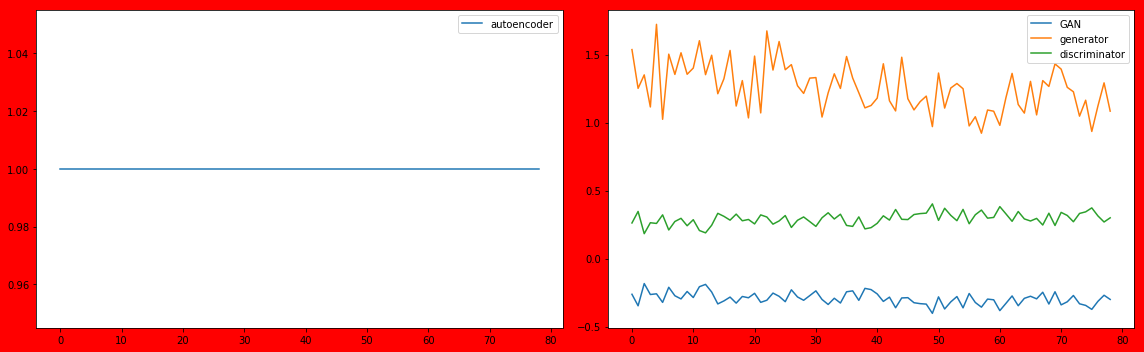

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 1]. loss g : 4.310388 loss d : 0.415214 time: 566.0 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take a message ? </s>
generate response:  ['yes , speaking . what time is the schedule ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' d rather have it . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ m going to the pub tonight . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m afraid i can ' t agree with you . i ' ve got a ton of moisturizer . i ' m afraid i can ' t </s>"]
true response:  you will need to pay late fees on these books . </s>
generate response:

[2 275] loss_ae: 1.000000 loss_g: 1.192953 loss_d_rel: 0.346461 time: 7.0 s
[2 280] loss_ae: 1.000000 loss_g: 1.196213 loss_d_rel: 0.263802 time: 7.1 s
[2 285] loss_ae: 1.000000 loss_g: 1.159211 loss_d_rel: 0.340450 time: 7.0 s
[2 290] loss_ae: 1.000000 loss_g: 1.119230 loss_d_rel: 0.296946 time: 7.1 s
[2 295] loss_ae: 1.000000 loss_g: 1.438997 loss_d_rel: 0.275994 time: 7.1 s
[2 300] loss_ae: 1.000000 loss_g: 1.167100 loss_d_rel: 0.273859 time: 7.4 s
[2 305] loss_ae: 1.000000 loss_g: 1.175741 loss_d_rel: 0.355065 time: 7.1 s
[2 310] loss_ae: 1.000000 loss_g: 1.057448 loss_d_rel: 0.334948 time: 7.2 s
[2 315] loss_ae: 1.000000 loss_g: 1.073772 loss_d_rel: 0.288124 time: 7.1 s
[2 320] loss_ae: 1.000000 loss_g: 1.315779 loss_d_rel: 0.250620 time: 6.6 s
[2 325] loss_ae: 1.000000 loss_g: 0.945760 loss_d_rel: 0.317477 time: 6.8 s
[2 330] loss_ae: 1.000000 loss_g: 0.862530 loss_d_rel: 0.355973 time: 7.2 s
[2 335] loss_ae: 1.000000 loss_g: 1.024010 loss_d_rel: 0.266152 time: 7.1 s
[2 340] loss

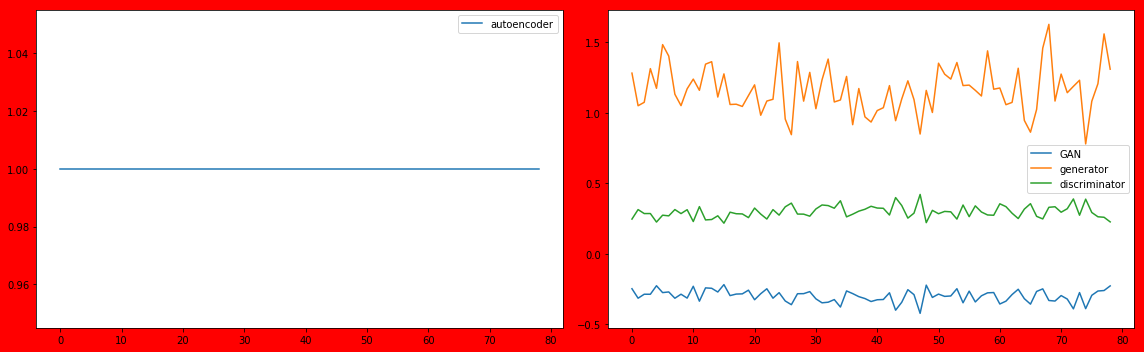

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 2]. loss g : 5.658166 loss d : 0.387153 time: 574.7 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take a message ? </s>
generate response:  ["yes , please . i ' m looking forward to seeing you again . </s>"]
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' m afraid i ' ll give you a discount . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ m looking for a pair of trousers . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m afraid i can ' t agree with you . i ' ve never seen the exhibits in the showroom . i suppose it ' s </s>"]
true response:  you will need to pay la

[3 265] loss_ae: 1.000000 loss_g: 1.033898 loss_d_rel: 0.299143 time: 6.4 s
[3 270] loss_ae: 1.000000 loss_g: 0.961234 loss_d_rel: 0.264655 time: 6.4 s
[3 275] loss_ae: 1.000000 loss_g: 1.068394 loss_d_rel: 0.271903 time: 6.5 s
[3 280] loss_ae: 1.000000 loss_g: 0.995266 loss_d_rel: 0.311705 time: 6.4 s
[3 285] loss_ae: 1.000000 loss_g: 1.311247 loss_d_rel: 0.240384 time: 6.6 s
[3 290] loss_ae: 1.000000 loss_g: 1.136279 loss_d_rel: 0.294983 time: 6.7 s
[3 295] loss_ae: 1.000000 loss_g: 1.031772 loss_d_rel: 0.306183 time: 6.7 s
[3 300] loss_ae: 1.000000 loss_g: 0.943438 loss_d_rel: 0.286826 time: 6.7 s
[3 305] loss_ae: 1.000000 loss_g: 0.846495 loss_d_rel: 0.236756 time: 7.1 s
[3 310] loss_ae: 1.000000 loss_g: 1.142716 loss_d_rel: 0.268676 time: 7.2 s
[3 315] loss_ae: 1.000000 loss_g: 1.584227 loss_d_rel: 0.290767 time: 7.1 s
[3 320] loss_ae: 1.000000 loss_g: 0.891490 loss_d_rel: 0.392193 time: 7.1 s
[3 325] loss_ae: 1.000000 loss_g: 1.193712 loss_d_rel: 0.239834 time: 7.2 s
[3 330] loss

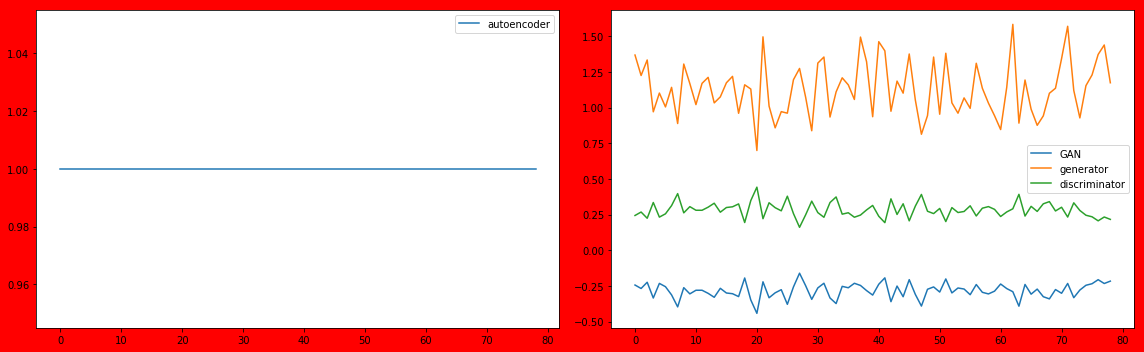

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 3]. loss g : 5.494321 loss d : 0.375012 time: 561.1 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take a message ? </s>
generate response:  ['yes , speaking . may i ask you ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' d rather have one more time . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ m going to the pub tonight . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m afraid i ' ll give you a hand in my bag . </s>"]
true response:  you will need to pay late fees on these books . </s>
generate response:  ['i don ’ t know how to use it . you can ’ t fin

[4 265] loss_ae: 1.000000 loss_g: 1.147450 loss_d_rel: 0.246166 time: 6.9 s
[4 270] loss_ae: 1.000000 loss_g: 1.246610 loss_d_rel: 0.220474 time: 7.0 s
[4 275] loss_ae: 1.000000 loss_g: 1.106250 loss_d_rel: 0.278648 time: 7.2 s
[4 280] loss_ae: 1.000000 loss_g: 1.275669 loss_d_rel: 0.235222 time: 7.3 s
[4 285] loss_ae: 1.000000 loss_g: 1.050909 loss_d_rel: 0.250602 time: 7.0 s
[4 290] loss_ae: 1.000000 loss_g: 1.435102 loss_d_rel: 0.263818 time: 7.1 s
[4 295] loss_ae: 1.000000 loss_g: 1.143488 loss_d_rel: 0.295873 time: 7.2 s
[4 300] loss_ae: 1.000000 loss_g: 1.141117 loss_d_rel: 0.280274 time: 7.2 s
[4 305] loss_ae: 1.000000 loss_g: 0.907767 loss_d_rel: 0.348479 time: 7.2 s
[4 310] loss_ae: 1.000000 loss_g: 1.099315 loss_d_rel: 0.252707 time: 7.2 s
[4 315] loss_ae: 1.000000 loss_g: 1.186786 loss_d_rel: 0.309150 time: 7.1 s
[4 320] loss_ae: 1.000000 loss_g: 1.296518 loss_d_rel: 0.299583 time: 7.1 s
[4 325] loss_ae: 1.000000 loss_g: 1.148336 loss_d_rel: 0.279254 time: 7.1 s
[4 330] loss

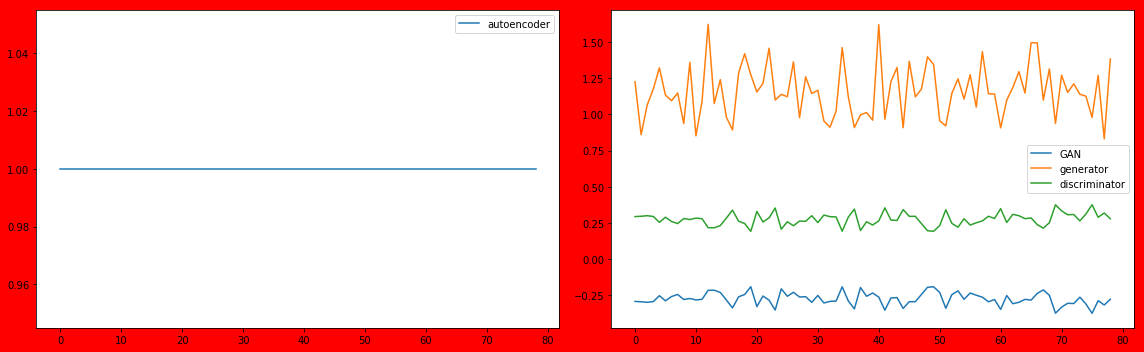

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 4]. loss g : 5.134530 loss d : 0.391863 time: 562.0 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take a message ? </s>
generate response:  ['yes . this is paula . may i ask you ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' d like to pay $ 200 . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ m looking for a cup of coffee . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m terribly sorry , but i didn ' t pay attention to me . i ' m afraid i ' ll give you a hand </s>"]
true response:  you will need to pay late fees on these books . </s>
generate response:  

[5 265] loss_ae: 1.000000 loss_g: 0.800128 loss_d_rel: 0.363260 time: 6.8 s
[5 270] loss_ae: 1.000000 loss_g: 1.155831 loss_d_rel: 0.306961 time: 6.9 s
[5 275] loss_ae: 1.000000 loss_g: 1.294389 loss_d_rel: 0.283783 time: 7.1 s
[5 280] loss_ae: 1.000000 loss_g: 1.333060 loss_d_rel: 0.219772 time: 7.3 s
[5 285] loss_ae: 1.000000 loss_g: 1.133463 loss_d_rel: 0.314643 time: 7.1 s
[5 290] loss_ae: 1.000000 loss_g: 1.151664 loss_d_rel: 0.200487 time: 7.2 s
[5 295] loss_ae: 1.000000 loss_g: 1.153881 loss_d_rel: 0.245500 time: 7.0 s
[5 300] loss_ae: 1.000000 loss_g: 1.438730 loss_d_rel: 0.182516 time: 6.7 s
[5 305] loss_ae: 1.000000 loss_g: 1.253937 loss_d_rel: 0.344689 time: 6.9 s
[5 310] loss_ae: 1.000000 loss_g: 1.448830 loss_d_rel: 0.258704 time: 7.0 s
[5 315] loss_ae: 1.000000 loss_g: 1.211646 loss_d_rel: 0.321104 time: 7.1 s
[5 320] loss_ae: 1.000000 loss_g: 1.356243 loss_d_rel: 0.294822 time: 6.8 s
[5 325] loss_ae: 1.000000 loss_g: 1.474032 loss_d_rel: 0.200324 time: 6.4 s
[5 330] loss

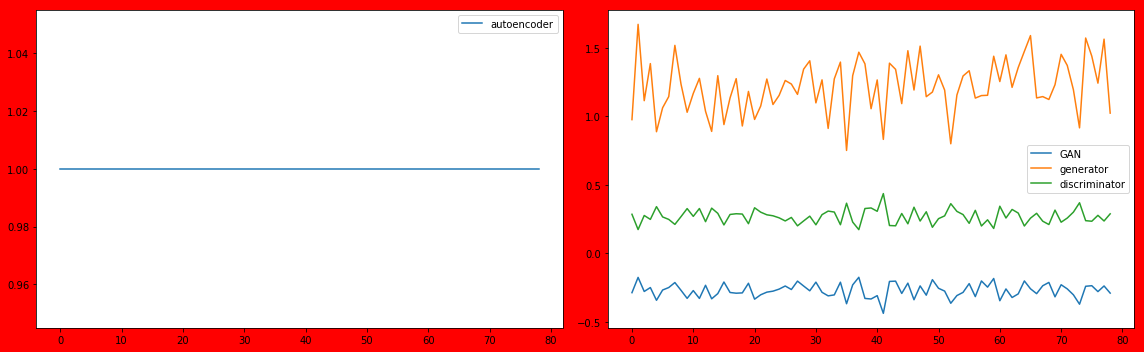

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 5]. loss g : 4.590567 loss d : 0.419758 time: 562.0 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take a message ? </s>
generate response:  ['yes . this is paula . may i ask you ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' d like to pay $ 20 . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ m going to the pub tonight . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m afraid i ' ll give you a hand in my mind . anyway , i ' ll give you a hand if i can find it ."]
true response:  you will need to pay late fees on these books . </s>
generate response:  ['i ’

[6 265] loss_ae: 1.000000 loss_g: 1.263307 loss_d_rel: 0.276200 time: 6.7 s
[6 270] loss_ae: 1.000000 loss_g: 1.105045 loss_d_rel: 0.264750 time: 6.5 s
[6 275] loss_ae: 1.000000 loss_g: 1.195310 loss_d_rel: 0.274410 time: 6.8 s
[6 280] loss_ae: 1.000000 loss_g: 1.103236 loss_d_rel: 0.279338 time: 6.8 s
[6 285] loss_ae: 1.000000 loss_g: 0.918214 loss_d_rel: 0.305789 time: 7.0 s
[6 290] loss_ae: 1.000000 loss_g: 1.044035 loss_d_rel: 0.248132 time: 7.1 s
[6 295] loss_ae: 1.000000 loss_g: 1.463686 loss_d_rel: 0.135614 time: 7.2 s
[6 300] loss_ae: 1.000000 loss_g: 0.851248 loss_d_rel: 0.353223 time: 7.0 s
[6 305] loss_ae: 1.000000 loss_g: 1.334594 loss_d_rel: 0.158208 time: 7.0 s
[6 310] loss_ae: 1.000000 loss_g: 1.263833 loss_d_rel: 0.223737 time: 7.0 s
[6 315] loss_ae: 1.000000 loss_g: 1.176921 loss_d_rel: 0.241501 time: 7.0 s
[6 320] loss_ae: 1.000000 loss_g: 1.231417 loss_d_rel: 0.197140 time: 7.1 s
[6 325] loss_ae: 1.000000 loss_g: 0.998229 loss_d_rel: 0.234956 time: 7.0 s
[6 330] loss

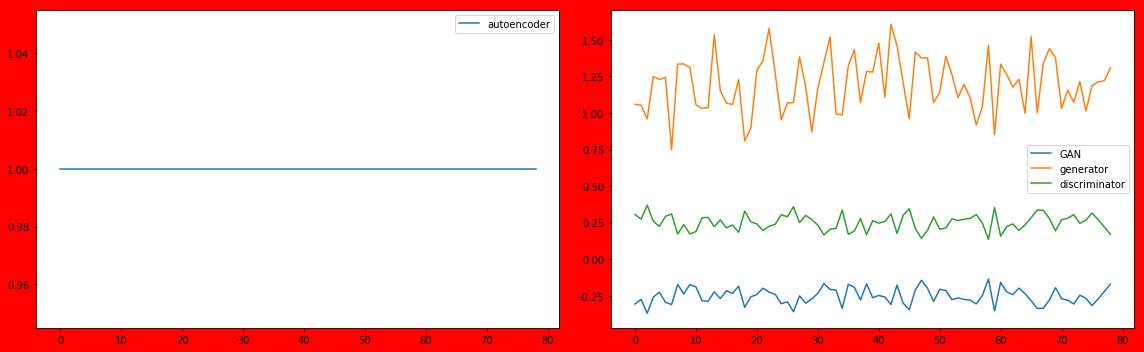

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 6]. loss g : 5.886488 loss d : 0.410586 time: 564.4 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take a message ? </s>
generate response:  ['yes . this is paula . may i ask who you are calling ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' d like a 20 - smoking room . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ m going to the pub tonight . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m terribly sorry , but i didn ' t say i ' m browsing down now . i ' m still in the mood for the last two"]
true response:  you will need to pay late fees on these books

[7 270] loss_ae: 1.000000 loss_g: 1.348140 loss_d_rel: 0.226065 time: 7.0 s
[7 275] loss_ae: 1.000000 loss_g: 1.357348 loss_d_rel: 0.216103 time: 7.0 s
[7 280] loss_ae: 1.000000 loss_g: 1.203740 loss_d_rel: 0.278118 time: 7.2 s
[7 285] loss_ae: 1.000000 loss_g: 1.513895 loss_d_rel: 0.168332 time: 7.2 s
[7 290] loss_ae: 1.000000 loss_g: 1.121502 loss_d_rel: 0.297917 time: 7.3 s
[7 295] loss_ae: 1.000000 loss_g: 1.124334 loss_d_rel: 0.217159 time: 7.0 s
[7 300] loss_ae: 1.000000 loss_g: 1.092001 loss_d_rel: 0.257754 time: 7.1 s
[7 305] loss_ae: 1.000000 loss_g: 1.122605 loss_d_rel: 0.255375 time: 7.0 s
[7 310] loss_ae: 1.000000 loss_g: 1.122704 loss_d_rel: 0.230408 time: 7.1 s
[7 315] loss_ae: 1.000000 loss_g: 1.502192 loss_d_rel: 0.214460 time: 7.2 s
[7 320] loss_ae: 1.000000 loss_g: 0.846108 loss_d_rel: 0.318519 time: 7.2 s
[7 325] loss_ae: 1.000000 loss_g: 1.070070 loss_d_rel: 0.189938 time: 6.9 s
[7 330] loss_ae: 1.000000 loss_g: 1.196107 loss_d_rel: 0.329840 time: 7.0 s
[7 335] loss

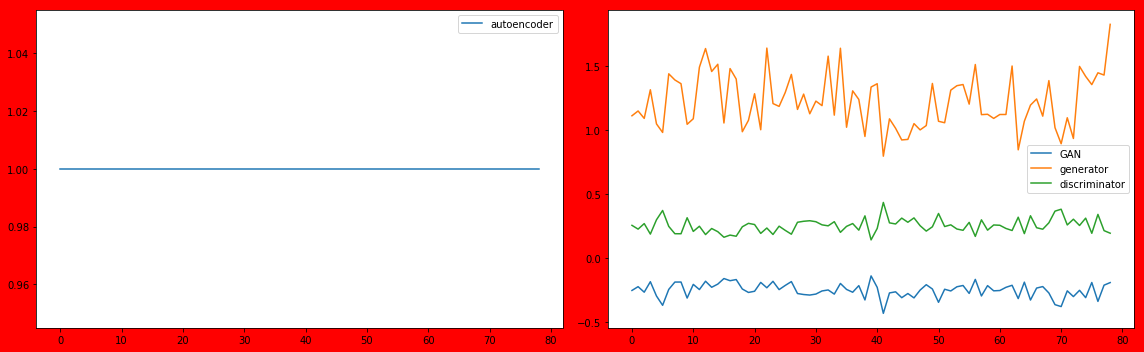

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 7]. loss g : 6.231240 loss d : 0.418028 time: 565.8 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take a message ? </s>
generate response:  ['yes . this is tom baker . may i ask who you are calling ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' d like another one . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ m looking for a <unk> . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m afraid i ' m afraid i ' ll give you another suggestion , but i ' d appreciate it . </s>"]
true response:  you will need to pay late fees on these books . </s>
generate respons

[8 255] loss_ae: 1.000000 loss_g: 1.373721 loss_d_rel: 0.189944 time: 6.7 s
[8 260] loss_ae: 1.000000 loss_g: 0.929278 loss_d_rel: 0.241419 time: 6.6 s
[8 265] loss_ae: 1.000000 loss_g: 1.722340 loss_d_rel: 0.177220 time: 6.5 s
[8 270] loss_ae: 1.000000 loss_g: 1.519340 loss_d_rel: 0.185278 time: 6.5 s
[8 275] loss_ae: 1.000000 loss_g: 1.331667 loss_d_rel: 0.291329 time: 6.4 s
[8 280] loss_ae: 1.000000 loss_g: 1.232831 loss_d_rel: 0.287089 time: 6.5 s
[8 285] loss_ae: 1.000000 loss_g: 1.593184 loss_d_rel: 0.161641 time: 6.5 s
[8 290] loss_ae: 1.000000 loss_g: 1.207151 loss_d_rel: 0.296937 time: 6.5 s
[8 295] loss_ae: 1.000000 loss_g: 1.482994 loss_d_rel: 0.145854 time: 6.4 s
[8 300] loss_ae: 1.000000 loss_g: 1.448192 loss_d_rel: 0.277497 time: 6.4 s
[8 305] loss_ae: 1.000000 loss_g: 1.058917 loss_d_rel: 0.277198 time: 6.8 s
[8 310] loss_ae: 1.000000 loss_g: 1.224717 loss_d_rel: 0.255194 time: 6.7 s
[8 315] loss_ae: 1.000000 loss_g: 1.643570 loss_d_rel: 0.241246 time: 6.6 s
[8 320] loss

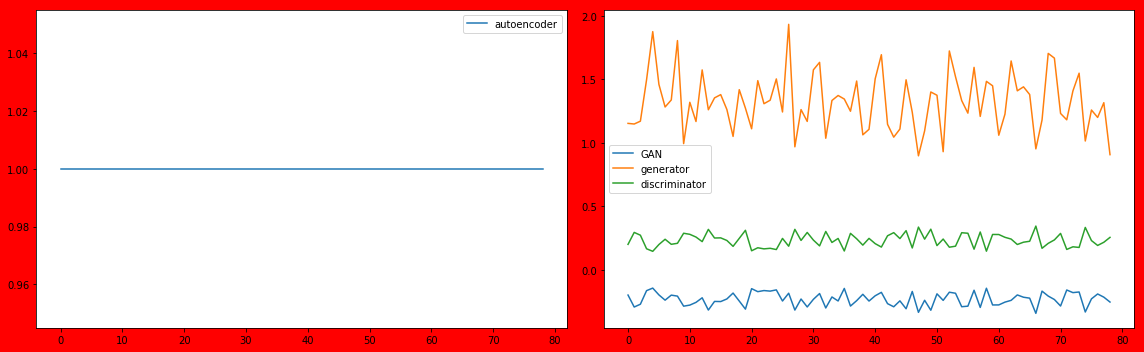

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 8]. loss g : 5.632167 loss d : 0.418922 time: 549.0 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take a message ? </s>
generate response:  ['yes . this is tom baker . may i ask who you are calling ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' d like another one , please . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ m going to have my own vacation tomorrow morning . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m afraid i ' ll give you another one . </s>"]
true response:  you will need to pay late fees on these books . </s>
generate response:  ['i ’ 

[9 260] loss_ae: 1.000000 loss_g: 1.441406 loss_d_rel: 0.210987 time: 7.2 s
[9 265] loss_ae: 1.000000 loss_g: 1.559690 loss_d_rel: 0.141899 time: 7.2 s
[9 270] loss_ae: 1.000000 loss_g: 1.314767 loss_d_rel: 0.147819 time: 7.1 s
[9 275] loss_ae: 1.000000 loss_g: 1.336697 loss_d_rel: 0.148737 time: 7.3 s
[9 280] loss_ae: 1.000000 loss_g: 1.215146 loss_d_rel: 0.211837 time: 7.2 s
[9 285] loss_ae: 1.000000 loss_g: 1.559496 loss_d_rel: 0.258638 time: 7.2 s
[9 290] loss_ae: 1.000000 loss_g: 1.621797 loss_d_rel: 0.148039 time: 7.1 s
[9 295] loss_ae: 1.000000 loss_g: 1.449190 loss_d_rel: 0.222185 time: 7.1 s
[9 300] loss_ae: 1.000000 loss_g: 1.316324 loss_d_rel: 0.276612 time: 7.2 s
[9 305] loss_ae: 1.000000 loss_g: 1.256336 loss_d_rel: 0.189609 time: 6.9 s
[9 310] loss_ae: 1.000000 loss_g: 1.185661 loss_d_rel: 0.127048 time: 6.9 s
[9 315] loss_ae: 1.000000 loss_g: 0.919423 loss_d_rel: 0.300963 time: 6.7 s
[9 320] loss_ae: 1.000000 loss_g: 1.445536 loss_d_rel: 0.216172 time: 6.7 s
[9 325] loss

KeyboardInterrupt: 

In [21]:
metrics=Metrics(corpus.word2vec)
model = Dialog_doubleGAN(config, n_tokens)
if corpus.word2vec is not None:
    print("Loaded word2vec")
    model.embedder.weight.data.copy_(torch.from_numpy(corpus.word2vec))
#     model.discriminator_relevance.embedder.weight.data.copy_(torch.from_numpy(corpus.word2vec))
    model.embedder.weight.data[0].fill_(0)
model.to(DEVICE)
model.zero_grad()

total_batch_count = 0 # 统计总共循环次数，用来动态调整温度参数
print_every = 5
best_state = None
max_metric = 0
valid_loss_ae = []
valid_loss_g = []
valid_loss_d_rel = []
max_temp = 10.0
temperature = 0.5

pretrain_epoch = 4
print('start pretraining AE...')
for i in range(5):
    print('pretrain AE epoch: ', i+1)
    total_train_batch = 0
    train_loader.epoch_init(32, config['diaglen'], 1, shuffle=False)
    while True:
        model.train()
        batch = train_loader.next_batch()
        total_train_batch += 32
        if batch is None:
#         if batch is None or total_train_batch >= 10000: # end of epoch
                break
        context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch
        context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
        context, context_lens, utt_lens, floors, response, res_lens\
                = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors), gVar(response), gVar(res_lens)
        # train encoder and decoder
        loss_AE = model.train_AE(context, context_lens, utt_lens, floors, response)
#         buf_loss[0] += float(loss_AE[0][1]) 
# recall_bleu, bow_extrema, bow_avg, bow_greedy, inter_dist1, inter_dist2, avg_len = evaluate(model, metrics, 
#                                   valid_loader, vocab, ivocab, repeat=1)

print('start pretraining D...')
for i in range(5):
    print('pretrain D epoch: ', i+1)
    loss_d_record = 0.0
    train_loader.epoch_init(32, config['diaglen'], 1, shuffle=False)
    n_iters = train_loader.num_batch
    while True:
        model.train()
        batch = train_loader.next_batch()
#         total_train_batch += 32
        if batch is None: # end of epoch
            break
        context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch
        context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
        context, context_lens, utt_lens, floors, response, res_lens\
                = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors), gVar(response), gVar(res_lens)
        loss_D, neg = model.train_D_relevance(context, context_lens, utt_lens, floors, 
                                             response, res_lens-1, temperature=0.4, is_pretrain=True)
        ref_str, _ = indexes2sent(neg, vocab, vocab["</s>"], vocab["<s>"])
#         print(ref_str[:5])
        loss_d_record += float(loss_D[0][1])
#     valid_loader.epoch_init(20, config['diaglen'], 1, shuffle=False)
#     valid_d_loss = valid(model, valid_loader, temp=0.3, mode='dis')
    print("loss D: %.6f"%(loss_d_record/n_iters))
#     print("valid loss D: %.6f"%(valid_d_loss[0]))
    
for epoch in range(10):
    print('Epoch: ', epoch+1)
    train_loader.epoch_init(32, config['diaglen'], 1, shuffle=True)
#     print('temperature: ', temperature)
    n_iters = train_loader.num_batch
    train_loss_ae = []
    train_loss_g = []
    train_loss_d_rel = []
    # 分别用来记录训练时候，生成器最顶层的梯度，最底层的梯度以及判别器最顶层的梯度
    train_grad_G_top_layer = []
    train_grad_G_bottom_layer = []
    train_grad_D_top_layer = []
    
    buf_loss = [0.0, 0.0, 0.0]
    epoch_begin = time()
    batch_count = 0
    batch_begin_time = time()
    total_train_batch = 0 # 记录训练的样本数量
    total_valid_batch = 0 # 记录测试的样本数量
    while True:
        model.train()
        loss_records = []
        batch = train_loader.next_batch()
        total_train_batch += 32
        if batch is None:
#         if batch is None or total_train_batch >= 1000: # end of epoch
            break
        context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch
        context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
        context, context_lens, utt_lens, floors, response, res_lens\
                = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors), gVar(response), gVar(res_lens)
        # train encoder and decoder
#         if epoch <= 2:
#             loss_AE = model.train_AE(context, context_lens, utt_lens, floors, response)
#             buf_loss[0] += float(loss_AE[0][1])   
#         else:
#             buf_loss[0] = 0
        # train generator
        loss_G = model.train_G(context, context_lens, utt_lens, floors, response, res_lens, temperature=0.4)
#         loss_AE = model.train_AE(context, context_lens, utt_lens, floors, response)
        buf_loss[1] += float(loss_G[0][1])
        # train discriminator
        for i in range(5):# train discriminator/critic
#         if batch_count % 5 == 0:
#             print('yes')
            loss_D, neg_sen = model.train_D_relevance(context, context_lens, utt_lens, floors, 
                                             response, res_lens-1, temperature=0.4, is_pretrain=False)
            ref_str, _ = indexes2sent(neg_sen, vocab, vocab["</s>"], vocab["<s>"])
#             print(ref_str[:2])
            if i==0:
                buf_loss[2] += float(loss_D[0][1])
#             if i==config['n_iters_d']-1:
#                 break
            batch = train_loader.next_batch()
            total_train_batch += 32
            if batch is None: # end of epoch
                break
            context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch
            context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
            context, context_lens, utt_lens, floors, response, res_lens\
                = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors), gVar(response), gVar(res_lens)                      
        batch_count += 1
        total_batch_count += 1
        if batch_count % print_every == 0:
            buf_loss[0] = np.exp(buf_loss[0] / print_every)
            buf_loss[1] = buf_loss[1] / print_every
            buf_loss[2] = buf_loss[2] / print_every
            print_flush('[%d %d] loss_ae: %.6f loss_g: %.6f loss_d_rel: %.6f time: %.1f s' %\
                  (epoch + 1, batch_count, buf_loss[0], buf_loss[1], buf_loss[2], time() - batch_begin_time))
            train_loss_ae.append(buf_loss[0])
            train_loss_g.append(buf_loss[1])
            train_loss_d_rel.append(buf_loss[2])
            batch_begin_time = time()
            buf_loss = [0, 0, 0]
#         train_grad_G_top_layer.append(torch.mean(model.context_encoder.rnn.weight_hh_l0.grad))
#         train_grad_G_top_layer.append(torch.mean(model.generator.out.weight.grad))
        train_grad_G_bottom_layer.append(torch.mean(model.generator.rnn.weight_hh_l0.grad))
#         train_grad_G_bottom_layer.append(torch.mean(model.embedder.weight.grad))
#         train_grad_D_top_layer.append(torch.mean(model.discriminator_relevance.convs[0].weight.grad))

#         temperature = get_fixed_temperature(max_temp, total_batch_count, 3000, 'exp')
    plot_loss(train_loss_ae, train_loss_g, train_loss_d_rel)
#     plot_gradient(train_grad_G_top_layer, 'G out layer')
#     plot_gradient(train_grad_G_bottom_layer, 'G rnn layer')
#     plot_gradient(train_grad_D_top_layer, 'D embedding layer')
    print_flush("Evaluating....")
    valid_loader.epoch_init(20, config['diaglen'], 1, shuffle=False)
    buf_loss = valid(model, valid_loader, temp=0.3, mode='dis')
#     valid_loss_ae.append(buf_loss[0])
#     valid_loss_g.append(buf_loss[1])
#     valid_loss_d_rel.append(buf_loss[2])
# #     valid_result.append(F1)
    print_flush('*'*60)
    print_flush('[epoch %d]. loss g : %.6f loss d : %.6f time: %.1f s'%(epoch+1, buf_loss[1], buf_loss[0], time()-epoch_begin))
    print_flush('*'*60)
    if (epoch+1) > 4:
        f_eval = open("../result/{}/{}/epoch{}.txt".format('GumbelGAN', 'SWDA', epoch), "w")
        recall_bleu, bow_extrema, bow_avg, bow_greedy, inter_dist1, inter_dist2, avg_len \
        = evaluate(model, metrics, test_loader, vocab, ivocab, f_eval, repeat=1)
    epoch_begin = time()
#     if F1 > max_metric:
#         best_state = model.state_dict()
#         max_metric = F1
#         print_flush("save model...")
#         torch.save(best_state, '../datasets/models/baseline_LSTM.pth')
#     epoch_begin = time()
#     if training_termination(valid_result):
#         print_flush("early stop at [%d] epoch!" % (epoch+1))
#         break


In [ ]:
plot_loss(valid_loss_ae, valid_loss_g, valid_loss_d_rel)